# Apartment Rent Prediction MS2

In [1]:
#######Libraries Importation########
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from joblib import load
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.model_selection import train_test_split , RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score as metrics
from sklearn import tree

**1.Loading the data**

In [2]:
df=pd.read_csv("ApartmentRentPrediction_Milestone2.csv")
df

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,RentCategory,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2.0,USD,No,Thumbnail,...,Medium-Priced Rent,Monthly,800,NaN,Cary,NC,35.7585,-78.7783,RentDigs.com,1568755960
1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1.0,USD,No,Thumbnail,...,Medium-Priced Rent,Monthly,795,640 West Wilson St,Madison,WI,43.0724,-89.4003,RentLingo,1577015508
2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1.0,USD,No,Thumbnail,...,Medium-Priced Rent,Monthly,560,2777 SW Archer Road,Gainesville,FL,29.6533,-82.3656,RentLingo,1577358921
3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",NaN,1.0,1.0,USD,No,Thumbnail,...,Low Rent,Monthly,600,534-542 Park Ave,Omaha,NE,41.2562,-96.0404,RentLingo,1577359849
4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",NaN,3.0,3.0,USD,No,Thumbnail,...,High Rent,Monthly,1600,2216 S Palm Grove Avenue,Los Angeles,CA,34.0372,-118.2972,RentLingo,1577360159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,5509251724,housing/rent/apartment,Prominence Apartments Two BR Luxury Apartment ...,Price from: 1158. Your hunt for apartments to ...,"Clubhouse,Gym,Patio/Deck,Pool",1.0,2.0,USD,No,Thumbnail,...,Medium-Priced Rent,Monthly,875,NaN,New London,CT,41.3498,-72.1062,RentDigs.com,1568781008
8996,5668612787,housing/rent/apartment,One BR 10001 Ne 1st St,"This unit is located at 10001 Ne first St, Bel...",NaN,1.0,1.0,USD,No,Thumbnail,...,High Rent,Monthly,824,10001 NE 1st St,Bellevue,WA,47.5988,-122.1507,RentLingo,1577358501
8997,5668617853,housing/rent/apartment,Two BR 95 E 2nd St,"This unit is located at 95 E second St, Fond D...","Parking,Storage",1.0,2.0,USD,No,Thumbnail,...,Low Rent,Monthly,844,95 E 2nd St,Fond Du Lac,WI,43.7815,-88.4411,RentLingo,1577358818
8998,5509093066,housing/rent/apartment,Pico Rivera - superb Apartment nearby fine din...,Top Rated by Yelp and 5 yrs in a Row! Style an...,"AC,Clubhouse,Dishwasher,Gated,Gym,Internet Acc...",1.0,2.0,USD,No,Thumbnail,...,Medium-Priced Rent,Monthly,489,NaN,Pico Rivera,CA,33.9883,-118.0875,RentDigs.com,1568772954


**2.Preprocessing**

In [3]:
#####################Nulls Detection#######
df.isna().sum()


id                 0
category           0
title              0
body               0
amenities       3185
bathrooms         30
bedrooms           7
currency           0
fee                0
has_photo          0
pets_allowed    3751
RentCategory       0
price_type         0
square_feet        0
address         2971
cityname          66
state             66
latitude           7
longitude          7
source             0
time               0
dtype: int64

In [4]:
X=df.drop(['RentCategory'],axis=1)
y=df['RentCategory']
y

0       Medium-Priced Rent
1       Medium-Priced Rent
2       Medium-Priced Rent
3                 Low Rent
4                High Rent
               ...        
8995    Medium-Priced Rent
8996             High Rent
8997              Low Rent
8998    Medium-Priced Rent
8999             High Rent
Name: RentCategory, Length: 9000, dtype: object

In [5]:
## 80% Train , 20% Test Mandatory ##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

**I.Handling Missing Values, Duplicates, Incorrect Formats.**

In [6]:
###########################conert df to string#################################
X_train = X_train.applymap(lambda x: x.lower() if isinstance(x, str) else x)
###########################duplicates###########################################

has_duplicates = X_train.duplicated().any()
if has_duplicates:
    X_train.drop_duplicates(inplace=True)
############################ Fill nulls ########################################
print(X_train.isna().sum())
#amenities
X_train['amenities'] = X_train['amenities'].fillna(0)
#bedrooms &bathrooms => fill nan with mode
X_train['bedrooms']=X_train['bedrooms'].fillna(X_train['bedrooms'].mode().iloc[0])
X_train['bathrooms']=X_train['bathrooms'].fillna(X_train['bathrooms'].mode().iloc[0])
#PetAllowwd =>if cats Or dogs =>yes else =>no
X_train['pets_allowed'] = X_train['pets_allowed'].fillna('No').apply(lambda x: 'Yes' if x != 'No' else x)
#address
X_train['address']=X_train['address'].fillna("Unknown")
#cityName
X_train['cityname']=X_train['cityname'].fillna(X_train['cityname'].mode().iloc[0])
#state
X_train['state']=X_train['state'].fillna(X_train['state'].mode().iloc[0])
#Latitude
X_train['latitude'] = X_train['latitude'].fillna(X_train['longitude'].mean())
#langitude
X_train['longitude'] = X_train['longitude'].fillna(X_train['longitude'].mean())
print(f"After {X_train.isna().sum()}")
######################IncorrectFormat#######################################
####Checking the type of each column
# print(f"type of each col {df.dtypes}")
#Bathrooms has some floating points which must be integer so we round it up
X_train['bathrooms'] = X_train['bathrooms'].apply(lambda x: math.ceil(x))
#convert it to int becuase no float values
X_train['bedrooms'] = X_train['bedrooms'].astype(np.int64)
#convert id_col based on the row index
X_train['id'] = range(len(X_train))
#Time_Col
X_train['time']=X_train['time']/X_train['time'].min()
###After converting we label encode it and we will drop this column as well as it has 1 value
X_train['price_type'] = X_train['price_type'].replace({'Weekly': 'Monthly', 'Monthly|Weekly': 'Monthly'})
###After converting we label encode it and we will drop this column as well as it has 1 value
X_train['category'] = X_train['category'].replace({'housing/rent/short_term': 'housing/rent/apartment', 'housing/rent/home': 'housing/rent/apartment'})



id                 0
category           0
title              0
body               0
amenities       2539
bathrooms         23
bedrooms           5
currency           0
fee                0
has_photo          0
pets_allowed    3011
price_type         0
square_feet        0
address         2372
cityname          51
state             51
latitude           5
longitude          5
source             0
time               0
dtype: int64
After id              0
category        0
title           0
body            0
amenities       0
bathrooms       0
bedrooms        0
currency        0
fee             0
has_photo       0
pets_allowed    0
price_type      0
square_feet     0
address         0
cityname        0
state           0
latitude        0
longitude       0
source          0
time            0
dtype: int64


In [7]:
##############Handle Format of RentCategory#########

print("before")
print(y_train)
##############Handle Format of RentCategory#########

y_train = y_train.apply(lambda x: x.lower().replace(' ', ''))
def categorize_rent_category(value):
    if 'low' in value:
        return 'Low'
    elif 'medium' in value:
        return 'Medium'
    elif 'high' in value:
        return 'High'
    else:
        return 'Unknown'

y_train = y_train.apply(categorize_rent_category)
print("after")
print(y_train)

before
6317    Medium-Priced Rent
740     Medium-Priced Rent
3781    Medium-Priced Rent
7850             High Rent
2963    Medium-Priced Rent
               ...        
5734             High Rent
5191              Low Rent
5390    Medium-Priced Rent
860     Medium-Priced Rent
7270             High Rent
Name: RentCategory, Length: 7200, dtype: object
after
6317    Medium
740     Medium
3781    Medium
7850      High
2963    Medium
         ...  
5734      High
5191       Low
5390    Medium
860     Medium
7270      High
Name: RentCategory, Length: 7200, dtype: object


In [8]:
######Extracting Price Info from body column######
def extract_price(text):
    prices = re.findall(r'\$(\d+(?:\.\d+)?)', text)
    if prices:
        return prices[0]
    else:
        return 0

X_train['extracted_price'] = X_train['body'].apply(extract_price)
X_train['extracted_price']=X_train['extracted_price'].astype(np.float64)
X_train['extracted_price']

6317    1425.0
740     1449.0
3781      25.0
7850    6400.0
2963    1299.0
         ...  
5734    2400.0
5191     895.0
5390       0.0
860     1200.0
7270    2125.0
Name: extracted_price, Length: 7200, dtype: float64

In [9]:
d1=X_train['cityname'].mode().iloc[0]
d2=X_train['state'].mode().iloc[0]
d3=X_train['state']
d4=X_train['cityname']
d5 = X_train['bathrooms'].mode().iloc[0]
dfff=X_train[X_train['cityname']==d1]
mostcity = dfff['extracted_price'].mean()
dffff=X_train[X_train['state']==d2]
moststate = dffff['extracted_price'].mean()
dfBath=X_train[X_train['bathrooms']==d5]
mostBath = dfBath['extracted_price'].mean()
d5=X_train['square_feet'].mean()
mostBath

901.8617886178862

In [10]:
def extract_price_df(text):
    if isinstance(text, str):  # Check if text is a string
        prices = re.findall(r'\$(\d+(?:\.\d+)?)', text)
        if prices:
            return prices[0]
    return 0


**II.Encoding**

In [11]:
##########Encoding##########
def encode_amenities(value):
    items = value.split(',') if isinstance(value, str) else []
    count=len(items)
    return count


if X_train['amenities'].dtype == object:
    X_train['amenities'] = X_train['amenities'].apply(encode_amenities)

#######################################################
def encode_rent_category(value):
    value = value.lower().replace(' ', '')
    if 'low' in value:
        return 0
    elif 'medium' in value:
        return 1
    elif 'high' in value:
        return 2
    else:
        return -1

# Apply the function to the 'RentCategory' column
y_train = y_train.apply(encode_rent_category)
######################################################
label_encoder = LabelEncoder()
X_train['source'] = label_encoder.fit_transform(X_train['source'])
X_train['price_type'] = label_encoder.fit_transform(X_train['price_type'])
X_train['address'] = label_encoder.fit_transform(X_train['address'])
X_train['body'] = label_encoder.fit_transform(X_train['body'])
X_train['title'] = label_encoder.fit_transform(X_train['title'])
X_train['pets_allowed'] = label_encoder.fit_transform(X_train['pets_allowed'])
X_train['has_photo'] = label_encoder.fit_transform(X_train['has_photo'])
X_train['fee'] = label_encoder.fit_transform(X_train['fee'])
X_train['currency'] = label_encoder.fit_transform(X_train['currency'])
#df['cityname'] = label_encoder.fit_transform(df['cityname'])
#df['state'] = label_encoder.fit_transform(df['state'])
label_encoder_path = 'le.joblib'

dump(label_encoder, label_encoder_path)


['le.joblib']

**III.Handling Outliers.**

In [12]:
###########Outliers#######
numerical_columns = ['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude']

# Iterate over each numerical column
for column in numerical_columns:
    # Calculate the Z-score for each value in the column
    z_scores = zscore(X_train[column])

    # Define a threshold for outliers (e.g., Z-score > 3 or < -3)
    threshold = 3

    # Identify outliers
    outliers = np.abs(z_scores) > threshold

    # Replace outliers with the nearest non-outlier value (Winsorization)
    lower_bound = X_train[column][~outliers].min()
    upper_bound = X_train[column][~outliers].max()
    X_train.loc[outliers, column] = np.where(X_train.loc[outliers, column] < lower_bound, lower_bound, X_train.loc[outliers, column])
    X_train.loc[outliers, column] = np.where(X_train.loc[outliers, column] > upper_bound, upper_bound, X_train.loc[outliers, column])



**IV.Columns Dropped**

In [13]:
###################Columns Dropped###############
columns_to_drop = ['id', 'category', 'title', 'body', 'currency', 'fee', 'source', 'time','price_type','address']
X_train = X_train.drop(columns=columns_to_drop)

In [14]:
X_train

,amenities,bathrooms,bedrooms,has_photo,pets_allowed,square_feet,cityname,state,latitude,longitude,extracted_price
6317,2,2,3,1,1,1459,ruskin,fl,27.7164,-82.4294,1425.0
740,2,2,3,1,1,1581,dallas,ga,33.9217,-84.8634,1449.0
3781,1,2,2,1,0,1123,las vegas,nv,36.1536,-115.1965,25.0
7850,0,3,3,1,0,2207,santa barbara,ca,34.4312,-119.7292,6400.0
2963,0,1,0,1,1,350,portland,or,45.5091,-122.6449,1299.0
...,...,...,...,...,...,...,...,...,...,...,...
5734,2,1,3,1,0,1700,seattle,wa,47.6160,-122.3275,2400.0
5191,1,1,1,1,0,715,san marcos,tx,29.8831,-97.9450,895.0
5390,2,1,2,1,1,803,arlington,tx,32.7583,-97.0880,0.0
860,6,1,1,1,1,758,delafield,wi,43.0619,-88.4017,1200.0


**V.Feature Engineering**

In [15]:
##### We will see if the features we did before in MS1 will help us here as well or no#####
X_train['NoOfRooms']=X_train['bathrooms']+X_train['bedrooms']
X_train['bed/bathrooms']=X_train['bedrooms']/X_train['bathrooms']
#df['Trial'] = df['squar_feet']/df['NoOfRooms']

In [16]:
#grouping the state according to its names and replacing with the avg price of each state
state_encoding = X_train.groupby('state')['extracted_price'].mean().reset_index()
state_encoding.columns = ['state', 'state_price_mean']
X_train = pd.merge(X_train, state_encoding, on='state', how='left')
X_train['state']=X_train['state_price_mean']
X_train.drop(['state_price_mean'], axis=1, inplace=True)

In [17]:
#grouping the city according to its names and replacing with the avg price of each city
city_encoding = X_train.groupby('cityname')['extracted_price'].mean().reset_index()
city_encoding.columns = ['cityname', 'city_price_mean']
X_train = pd.merge(X_train, city_encoding, on='cityname', how='left')
X_train['cityname']=X_train['city_price_mean']
X_train.drop(['city_price_mean'], axis=1, inplace=True)

In [18]:
X_train = X_train.rename(columns={'cityname': 'CityavgRentprice', 'state': 'StateavgRentprice'})

In [19]:
X_train

,amenities,bathrooms,bedrooms,has_photo,pets_allowed,square_feet,CityavgRentprice,StateavgRentprice,latitude,longitude,extracted_price,NoOfRooms,bed/bathrooms
0,2,2,3,1,1,1459,1433.000000,1223.144033,27.7164,-82.4294,1425.0,5,1.5
1,2,2,3,1,1,1581,779.855263,657.015748,33.9217,-84.8634,1449.0,5,1.5
2,1,2,2,1,0,1123,289.500000,604.758242,36.1536,-115.1965,25.0,4,1.0
3,0,3,3,1,0,2207,4016.666667,2187.477876,34.4312,-119.7292,6400.0,6,1.0
4,0,1,0,1,1,350,1593.506024,1553.655172,45.5091,-122.6449,1299.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,2,1,3,1,0,1700,2080.016949,935.483607,47.6160,-122.3275,2400.0,4,3.0
7196,1,1,1,1,0,715,1086.000000,924.050414,29.8831,-97.9450,895.0,2,1.0
7197,2,1,2,1,1,803,606.135593,924.050414,32.7583,-97.0880,0.0,3,2.0
7198,6,1,1,1,1,758,1200.000000,1237.828829,43.0619,-88.4017,1200.0,2,1.0


In [20]:
##############New Feature ALERTTTTT############ AvgAreaState
X_train['longitude_range'] = pd.cut(X_train['longitude'], bins=10)
X_train['latitude_range'] = pd.cut(X_train['latitude'], bins=10)


range_means = X_train.groupby(['longitude_range', 'latitude_range'])['extracted_price'].mean()


X_train['AvgAreaPrice'] = X_train.groupby(['longitude_range', 'latitude_range'])['extracted_price'].transform('mean')


X_train.drop(['longitude_range', 'latitude_range'], axis=1, inplace=True)

In [21]:
#########NEW FEATURE ALERT!!!!!!!!!!!!################
X_train['CityStateAvg']=(X_train['CityavgRentprice']+X_train['StateavgRentprice'])/2

In [22]:
#########NEW FEATURE ALERT!!!!!!!!!!!!################
bath_encoding = X_train.groupby('bathrooms')['extracted_price'].mean().reset_index()
bath_encoding.columns = ['bathrooms', 'avgBathroomsPrice']
X_train = pd.merge(X_train, bath_encoding, on='bathrooms', how='left')

In [23]:
#########NEW FEATURE ALERT!!!!!!!!!!!!################
X_train['Trial'] = X_train['CityavgRentprice'] + X_train['square_feet']/2 + X_train['avgBathroomsPrice']/3 +X_train['bedrooms']*20

In [24]:
X_train

,amenities,bathrooms,bedrooms,has_photo,pets_allowed,square_feet,CityavgRentprice,StateavgRentprice,latitude,longitude,extracted_price,NoOfRooms,bed/bathrooms,AvgAreaPrice,CityStateAvg,avgBathroomsPrice,Trial
0,2,2,3,1,1,1459,1433.000000,1223.144033,27.7164,-82.4294,1425.0,5,1.5,1111.251748,1328.072016,1009.227809,2558.909270
1,2,2,3,1,1,1581,779.855263,657.015748,33.9217,-84.8634,1449.0,5,1.5,779.757862,718.435506,1009.227809,1966.764533
2,1,2,2,1,0,1123,289.500000,604.758242,36.1536,-115.1965,25.0,4,1.0,674.067416,447.129121,1009.227809,1227.409270
3,0,3,3,1,0,2207,4016.666667,2187.477876,34.4312,-119.7292,6400.0,6,1.0,1726.148867,3102.072271,2525.171806,6021.890602
4,0,1,0,1,1,350,1593.506024,1553.655172,45.5091,-122.6449,1299.0,1,0.0,1524.418750,1573.580598,901.861789,2069.126620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,2,1,3,1,0,1700,2080.016949,935.483607,47.6160,-122.3275,2400.0,4,3.0,919.914209,1507.750278,901.861789,3290.637545
7196,1,1,1,1,0,715,1086.000000,924.050414,29.8831,-97.9450,895.0,2,1.0,1180.452191,1005.025207,901.861789,1764.120596
7197,2,1,2,1,1,803,606.135593,924.050414,32.7583,-97.0880,0.0,3,2.0,524.887805,765.093004,901.861789,1348.256189
7198,6,1,1,1,1,758,1200.000000,1237.828829,43.0619,-88.4017,1200.0,2,1.0,1400.788732,1218.914414,901.861789,1899.620596


In [25]:
y_train

6317    1
740     1
3781    1
7850    2
2963    1
       ..
5734    2
5191    0
5390    1
860     1
7270    2
Name: RentCategory, Length: 7200, dtype: int64

In [26]:
y_train.reset_index(drop=True, inplace=True)

In [27]:
y_train

0       1
1       1
2       1
3       2
4       1
       ..
7195    2
7196    0
7197    1
7198    1
7199    2
Name: RentCategory, Length: 7200, dtype: int64

**3.Selecting Best Features**

In [28]:
######################Selecting top k features##############

# selected_features = df[['amenities', 'bathrooms', 'bedrooms', 'has_photo', 'pets_allowed', 'square_feet', 'latitude', 'longitude', 'extracted_price', 'bed/bathrooms', 'NoOfRooms', 'RentCategory','CityavgRentprice','StateavgRentprice','Trial','CityStateAvg','AvgAreaPrice','avgBathroomsPrice']]


# X = selected_features.drop(columns=['RentCategory'])  # Features
# y = selected_features['RentCategory']  # Target variable


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
s_scaler_path = 'sc.joblib'

dump(scaler, s_scaler_path)
selector = SelectKBest(score_func=f_classif, k=7) ####khdt top 7 features
X_selected = selector.fit_transform(X_scaled, y_train)

selector_path = 'selector.joblib'

dump(selector, selector_path)
selected_indices = selector.get_support(indices=True)


selected_feature_names = X_train.columns[selected_indices]


df_selected = pd.DataFrame(X_selected, columns=selected_feature_names)


df_selected['RentCategory'] = y_train


print(df_selected.head())

   bathrooms  square_feet  CityavgRentprice  extracted_price  NoOfRooms  \
0   0.997783     1.098366          0.502177         0.367061   1.354174   
1   0.997783     1.354466         -0.318391         0.389550   1.354174   
2   0.997783     0.393043         -0.934441        -0.944821   0.629909   
3   2.651948     2.668550          3.748126         5.028925   2.078439   
4  -0.656382    -1.229620          0.703826         0.248991  -1.542885   

   CityStateAvg     Trial  RentCategory  
0      0.502803  0.735055             1  
1     -0.537019  0.093692             1  
2     -0.999771 -0.707118             1  
3      3.528614  4.485876             2  
4      0.921553  0.204562             1  


In [29]:
feature_scores = selector.scores_

feature_scores_df = pd.DataFrame({'Feature': X_train.columns, 'Score': feature_scores})

sorted_features = feature_scores_df.sort_values(by='Score', ascending=False)

sorted_features

,Feature,Score
16,Trial,1020.562566
10,extracted_price,993.046057
5,square_feet,770.312608
14,CityStateAvg,682.439738
1,bathrooms,628.424165
6,CityavgRentprice,571.020985
11,NoOfRooms,558.271533
13,AvgAreaPrice,515.163637
7,StateavgRentprice,494.034107
15,avgBathroomsPrice,392.337369


In [30]:
X=df_selected.drop(columns=['RentCategory'])
X

,bathrooms,square_feet,CityavgRentprice,extracted_price,NoOfRooms,CityStateAvg,Trial
0,0.997783,1.098366,0.502177,0.367061,1.354174,0.502803,0.735055
1,0.997783,1.354466,-0.318391,0.389550,1.354174,-0.537019,0.093692
2,0.997783,0.393043,-0.934441,-0.944821,0.629909,-0.999771,-0.707118
3,2.651948,2.668550,3.748126,5.028925,2.078439,3.528614,4.485876
4,-0.656382,-1.229620,0.703826,0.248991,-1.542885,0.921553,0.204562
...,...,...,...,...,...,...,...
7195,-0.656382,1.604268,1.315047,1.280693,0.629909,0.809270,1.527604
7196,-0.656382,-0.463420,0.066229,-0.129580,-0.818620,-0.048199,-0.125796
7197,-0.656382,-0.278693,-0.536641,-0.968247,-0.094356,-0.457438,-0.576227
7198,-0.656382,-0.373156,0.209451,0.156223,-0.818620,0.316619,0.020967


In [31]:
y=df_selected['RentCategory']
y

0       1
1       1
2       1
3       2
4       1
       ..
7195    2
7196    0
7197    1
7198    1
7199    2
Name: RentCategory, Length: 7200, dtype: int64

**4.Train Test Split and Features Importance**

In [216]:
# ####################For the RF the most important features##########
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(X, y)
# feature_importance_rf = rf.feature_importances_
# feature_importance_rf_series = pd.Series(feature_importance_rf)
# feature_importance_rf_sorted = feature_importance_rf_series.sort_values(ascending=False)
# print("\nRandom Forest feature importance:")
# print(feature_importance_rf_sorted)

# plt.figure(figsize=(10, 6))
# plt.title("Random Forest Feature Importances")
# plt.bar(range(X.shape[1]), feature_importance_rf_sorted, align="center")
# plt.xticks(range(y.shape[1]), selected_feature_names[feature_importance_rf_sorted.index], rotation=90)
# plt.xlabel("Feature")
# plt.ylabel("Importance")
# plt.tight_layout()
# plt.show()

In [217]:
# ####################For the DT the most important features##########

# dt_classifier = DecisionTreeClassifier(random_state=42)
# dt_classifier.fit(X, y)


# importances = dt_classifier.feature_importances_
# indices = np.argsort(importances)[::-1]


# print("Feature Importances:")
# for i in range(X_train.shape[1]):
#     print(f"{i+1}. {selected_feature_names[indices[i]]}: {importances[indices[i]]}")


# plt.figure(figsize=(10, 6))
# plt.title("Feature Importances")
# plt.bar(range(X_train.shape[1]), importances[indices], align="center")
# plt.xticks(range(X_train.shape[1]), selected_feature_names[indices], rotation=90)
# plt.xlabel("Feature")
# plt.ylabel("Importance")
# plt.tight_layout()
# plt.show()

**5.Applying 3 different Classification Models atleast.**

In [33]:
Xy_test = pd.concat([X_test, y_test], axis=1)

In [34]:
X_test,y_test=preprocess_data(Xy_test)

   state  extracted_price
0     ak       875.363636
1     al       893.085714
2     ar       915.976744
3     az      1064.613333
4     ca       986.625000
5     co       984.721591
6     ct       911.779661
7     dc       912.264706
8     de       897.250000
9     fl      1091.346734
10    ga      1081.723502
11    hi       790.000000
12    ia      1012.299145
13    id       995.090909
14    il      1099.084337
15    in      1012.825758
16    ks       843.733333
17    ky       944.037037
18    la      1324.000000
19    ma      1070.326087
20    md      1075.758475
21    mi       973.368421
22    mn       903.427481
23    mo      1027.594406
24    ms      1107.000000
25    mt      1024.833333
26    nc      1059.779468
27    nd      1051.133333
28    ne      1021.129630
29    nh       961.555556
30    nj      1028.366834
31    nm       888.142857
32    nv      1202.058824
33    ny      1228.121951
34    oh      1026.585227
35    ok       935.628571
36    or       924.880000
37    pa    

C:\Users\20127\AppData\Local\Temp\ipykernel_192\1145021885.py:86: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  new = pd.merge(new, bath_encoding, on='bathrooms', how='left')


**Model I:Random Forest             (Hypertuning& at least study 3 different values for 2 different parameters 1 thabet w eltany variable)**

In [35]:
##################Model 1 with hyperparameter tuning############
####RandomForest##########

rf_classifier = RandomForestClassifier(random_state=42)



# grid_search = GridSearchCV(estimator=rf_classifier, param_grid = {
#     'n_estimators': [30,50,100],
#     'min_samples_split':[1, 2, 5],
#     'max_depth':[5,7,10]#third choice
# })
rf_classifier = RandomForestClassifier(max_depth= 10, min_samples_split= 5, n_estimators= 30,random_state=42)

rf_classifier.fit(X, y.ravel())

# 
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)


# best_rf = grid_search.best_estimator_


rf_prediction = rf_classifier.predict(X_test)
rf_prediction_train = rf_classifier.predict(X)

accuracy_rf_test = accuracy_score(y_test, rf_prediction)
accuracy_rf_train = accuracy_score(y, rf_prediction_train)
print("RandomForest Accuracy gb test:", accuracy_rf_test)
print("RandomForest Accuracy gb train:", accuracy_rf_train)




RandomForest Accuracy gb test: 0.8333333333333334
RandomForest Accuracy gb train: 0.9290277777777778


C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [36]:
# estimator = grid_search.best_estimator_.estimators_[0]

# # Visualize the decision tree
# plt.figure(figsize=(20, 15))
# tree.plot_tree(estimator, feature_names=X.columns.tolist(), class_names=['0', '1','2'], filled=True)
# plt.show()

**Model II:Decision Tree              (Hypertuning& at least study 3 different values for 2 different parameters 1 thabet w eltany variable)**

In [37]:
##################Model 2 with hyperparameter tuning############
#######Decision Tree########
# param_grid = {
#     'min_samples_split': [1, 2, 5],
#     'min_samples_leaf': [1, 2, 5],###third choice
#     'max_features': [2,5,10]

# }
dt_classifier = DecisionTreeClassifier(min_samples_split= 2, min_samples_leaf= 1, max_features= 5,random_state=42)
#random_search = RandomizedSearchCV(estimator=dt_classifier, param_distributions=param_grid, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


dt_classifier.fit(X, y.ravel())


# print("Best Parameters:", random_search.best_params_)
# print("Best Score:", random_search.best_score_)


# best_dt = random_search.best_estimator_


dt_prediction = dt_classifier.predict(X_test)
dt_prediction_train = dt_classifier.predict(X)

accuracy_dt_test = accuracy_score(y_test, dt_prediction)
accuracy_dt_train = accuracy_score(y, dt_prediction_train)
print("Decision Tree Accuracy dt test:", accuracy_dt_test)
print("Decision Tree Accuracy dt train:", accuracy_dt_train)


Decision Tree Accuracy dt test: 0.8055555555555556
Decision Tree Accuracy dt train: 0.9984722222222222


C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


**Model III:Gradient Boosting               (Hypertuning& at least study 3 different values for 2 different parameters 1 thabet w eltany variable)**

In [38]:
##################Model 3 with hyperparameter tuning############
#######Gradient Boosting########

gb_classifier = GradientBoostingClassifier(random_state=42,learning_rate= 1, n_estimators= 30)
#### 3ayzeen hyper parameter 3###
# grid_search = GridSearchCV(estimator=gb_classifier, param_grid = {
#     'n_estimators': [20,30,50],
#     'learning_rate': [0.01,0.1,1]
# })


gb_classifier.fit(X, y.ravel())


# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)


# best_gb = grid_search.best_estimator_


gb_prediction = gb_classifier.predict(X_test)
gb_prediction_train = gb_classifier.predict(X)

accuracy_gb_test = accuracy_score(y_test, gb_prediction)
accuracy_gb_train = accuracy_score(y, gb_prediction_train)
print("Gradient Boosting Accuracy gb test:", accuracy_gb_test)
print("Gradient Boosting Accuracy gb train:", accuracy_gb_train)


Gradient Boosting Accuracy gb test: 0.8372222222222222
Gradient Boosting Accuracy gb train: 0.9618055555555556


C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


**Model IV:SVM (Hypertuning& at least study 3 different values for 2 different parameters 1 thabet w eltany variable)**

In [39]:

svm_classifier = SVC(kernel='rbf',C=10,gamma='scale',random_state=42)
# grid_search = GridSearchCV(estimator=svm_classifier, param_grid = {
#     'kernel': ['poly','rbf','linear'], 
#     'C': [0.1, 1, 10],     
#     'gamma': ['scale', 'auto','sqrt']  ##Third choice
# })

svm_classifier.fit(X, y.ravel())


# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)


# best_svm = grid_search.best_estimator_


svm_prediction = svm_classifier.predict(X_test)
svm_prediction_train = svm_classifier.predict(X)

accuracy_svm_test = accuracy_score(y_test, svm_prediction)
accuracy_svm_train = accuracy_score(y, svm_prediction_train)
print("SVM Accuracy test:", accuracy_svm_test)
print("SVM Accuracy train:", accuracy_svm_train)


C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


SVM Accuracy test: 0.8188888888888889
SVM Accuracy train: 0.8730555555555556


**Model V:KNN (Hypertuning& at least study 3 different values for 2 different parameters 1 thabet w eltany variable)**

In [40]:

knn_classifier = KNeighborsClassifier(n_neighbors= 9, p= 1, weights= 'distance')


# grid_search = GridSearchCV(estimator=knn_classifier, param_grid = {
#     'n_neighbors': [3, 5, 7, 9],  
#     'weights': ['uniform', 'distance'],  
#     'p': [1, 2, 3]  
# })


knn_classifier.fit(X, y.ravel())


# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

# best_knn = grid_search.best_estimator_


knn_prediction = knn_classifier.predict(X_test)
knn_prediction_train = knn_classifier.predict(X)

accuracy_knn_test = accuracy_score(y_test, knn_prediction)
accuracy_knn_train = accuracy_score(y, knn_prediction_train)
print("KNN Accuracy test:", accuracy_knn_test)
print("KNN Accuracy train:", accuracy_knn_train)


KNN Accuracy test: 0.7605555555555555
KNN Accuracy train: 0.9984722222222222


C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


**Model VI:XGBoost (Hypertuning& at least study 3 different values for 2 different parameters 1 thabet w eltany variable)**

In [41]:

xgb_classifier = xgb.XGBClassifier(random_state=42,gamma= 0, learning_rate= 0.1, max_depth= 7, n_estimators= 200)


# grid_search = GridSearchCV(estimator=xgb_classifier, param_grid= {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01],
#     'n_estimators': [100, 200], 
#     'gamma': [0, 1]
# })

xgb_classifier.fit(X, y.ravel())


# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

# best_xgb = grid_search.best_estimator_


xgb_prediction = xgb_classifier.predict(X_test)
xgb_prediction_train = xgb_classifier.predict(X)

accuracy_xgb_test = accuracy_score(y_test, xgb_prediction)
accuracy_xgb_train = accuracy_score(y, xgb_prediction_train)
print("XGB Accuracy test:", accuracy_xgb_test)
print("XGB Accuracy train:", accuracy_xgb_train)

XGB Accuracy test: 0.8394444444444444
XGB Accuracy train: 0.985


**ENSEMBLE LEARNING: (Combining 2 models or more to predict)(Voting or Stacking Approaches)**

In [42]:
#########################ENSEMBLE LEARNING##################
# ######################### STACKING ##################
estimators = [('Desision tree',DecisionTreeClassifier(min_samples_split= 2, min_samples_leaf= 2, max_features= 5,random_state=42)),
              ('Random Forest',RandomForestClassifier(max_depth= 10, min_samples_split= 2, n_estimators= 50,random_state=42)),
              ('XGBoost',xgb.XGBClassifier(gamma= 1, learning_rate= 0.1, max_depth= 7, n_estimators= 100,random_state=42))
              ]

stackingclass = StackingClassifier(estimators=estimators,final_estimator=LogisticRegression(random_state= 42))
stackingclass.fit(X,y).score(X_test,y_test)

y_pred = stackingclass.predict(X_test)

stacking_test = accuracy_score(y_test, y_pred)

print("stacking Accuracy test:", stacking_test)


stacking Accuracy test: 0.8427777777777777


C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [43]:
########### VOTING ##########
log_clf = LogisticRegression(random_state= 42 )

estimators = [('svm', SVC(C=10, gamma ='auto', kernel= 'rbf',random_state=42)),
              ('knn', KNeighborsClassifier(n_neighbors=9, p=1, weights= 'distance')),
              ('gradient boosting',GradientBoostingClassifier(learning_rate= 1, n_estimators=50,random_state=42))
              ]

voting_clf = VotingClassifier(estimators=estimators,voting="hard")

voting_clf.fit(X,y)
y_pred = voting_clf.predict(X_test)

voting_test = accuracy_score(y_test, y_pred)
print("voting Accuracy test:", voting_test)




C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


voting Accuracy test: 0.825


C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


**6.Saving the models and preprocessing (scaling, handling missing values and encoding) on train data to be ready to use them on the test data**

**TO BE READY TO USE THIS LOADED SCRIPT ALREADY**

In [44]:
##################Saving#################
############Saving the models#########
rf_model_path = 'rf.joblib'
dt_model_path = 'dt.joblib'
gb_model_path = 'gb.joblib'
svm_model_path='svm.joblib'
knn_model_path='knn.joblib'
xgb_model_path='xgb.joblib'


dump(rf_classifier, rf_model_path)
dump(dt_classifier, dt_model_path)
dump(gb_classifier, gb_model_path)
dump(svm_classifier, svm_model_path)
dump(knn_classifier, knn_model_path)
dump(xgb_classifier, xgb_model_path)


print("Models saved successfully!")

Models saved successfully!


In [45]:
############Loading Models##############
try:
    rf_classifier = load('rf.joblib')
    dt_classifier = load('dt.joblib')
    gb_classifier = load('gb.joblib')
    svm_classifier = load('svm.joblib')
    knn_classifier = load('knn.joblib')
    xgb_classifier = load('xgb.joblib')


    print("Models loaded successfully!")
except FileNotFoundError:
    print("Saved models not found. Training models from scratch...")

    rf_classifier = RandomForestClassifier(max_depth= 10, min_samples_split= 5, n_estimators= 30)
    rf_classifier.fit(X_train, y_train)

    dt_classifier = DecisionTreeClassifier(min_samples_split= 2, min_samples_leaf= 1, max_features= 5)
    dt_classifier.fit(X_train, y_train)

    gb_classifier = GradientBoostingClassifier(learning_rate= 1, n_estimators= 30)
    gb_classifier.fit(X_train, y_train)
    
    svm_classifier = SVC(kernel='rbf',C=10,gamma='scale',random_state=42)
    svm_classifier.fit(X_train, y_train)
    
    knn_classifier = KNeighborsClassifier(n_neighbors= 9, p= 1, weights= 'distance')
    knn_classifier.fit(X_train, y_train)
    
    xgb_classifier = xgb.XGBClassifier(random_state=42,gamma= 0, learning_rate= 0.1, max_depth= 7, n_estimators= 200)
    xgb_classifier.fit(X_train, y_train)

    print("Models trained successfully!")

Models loaded successfully!


**7.VISUALIZATIONS AND Results**

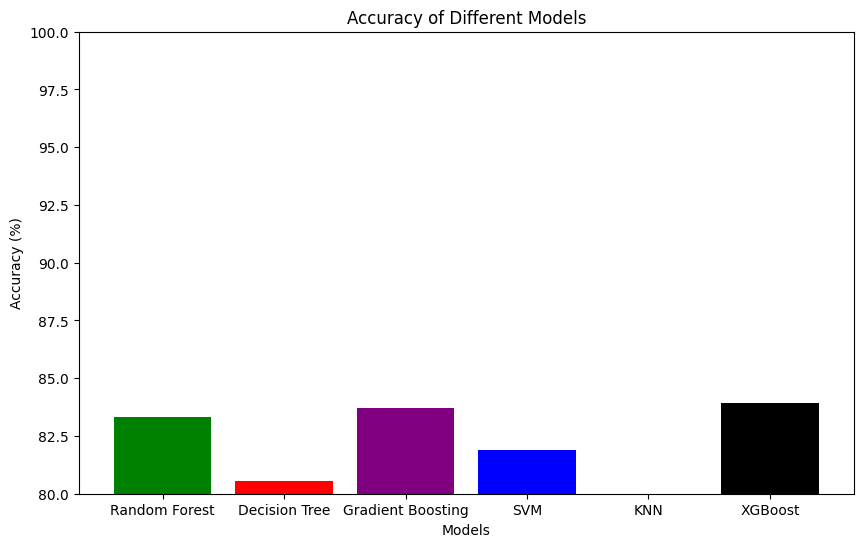

In [46]:
####Summarize the classification accuracy, total training time, and total test time using three bar graphs.### Mandatory
###########Visualize the result#############
models = ['Random Forest', 'Decision Tree', 'Gradient Boosting','SVM','KNN','XGBoost']
accuracies = [accuracy_rf_test* 100,
              accuracy_dt_test * 100,
              accuracy_gb_test * 100,
             accuracy_svm_test * 100,
             accuracy_knn_test * 100,
             accuracy_xgb_test * 100]


plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=[ 'green', 'red', 'purple','blue','yellow','black'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Models')
plt.ylim(80, 100)
plt.show()



In [47]:
import time

training_times = {}
testing_times = {}
#################Function to calculate time############
def measure_time(model, X_train, y_train, X_test):
    #training time
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times[type(model).__name__] = training_time
    
    #testing time
    start_time = time.time()
    model.predict(X_test)
    end_time = time.time()
    testing_time = end_time - start_time
    testing_times[type(model).__name__] = testing_time



C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\20127\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

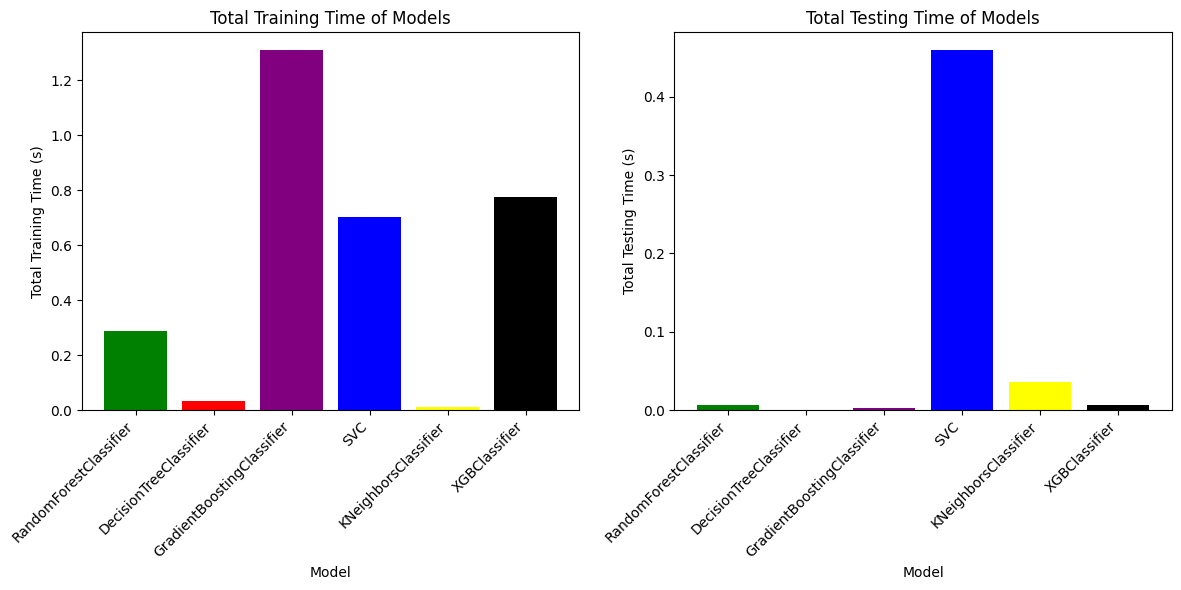

In [48]:
#######################Total Training Time , Total Testing time####################with the best parameters from the gridsearch
rf_classifier = RandomForestClassifier(max_depth= 10, min_samples_split= 5, n_estimators= 30)
dt_classifier = DecisionTreeClassifier(min_samples_split= 2, min_samples_leaf= 1, max_features= 5)
gb_classifier = GradientBoostingClassifier(learning_rate= 1, n_estimators= 30)
svm_classifier = SVC(kernel='rbf',C=10,gamma='scale',random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors= 9, p= 1, weights= 'distance')
xgb_classifier = xgb.XGBClassifier(random_state=42,gamma= 0, learning_rate= 0.1, max_depth= 7, n_estimators= 200)
   

models = [rf_classifier, dt_classifier, gb_classifier, svm_classifier, knn_classifier, xgb_classifier]

for model in models:
    measure_time(model, X, y, X_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(training_times.keys(), training_times.values(), color=[ 'green', 'red', 'purple','blue','yellow','black'])
plt.xlabel('Model')
plt.ylabel('Total Training Time (s)')
plt.title('Total Training Time of Models')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(testing_times.keys(), testing_times.values(), color=[ 'green', 'red', 'purple','blue','yellow','black'])
plt.xlabel('Model')
plt.ylabel('Total Testing Time (s)')
plt.title('Total Testing Time of Models')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [49]:
evaluation_results={
    'Model' :['Random Forest', 'Decision Tree', 'Gradient Boosting','SVM','KNN','XGBoost'],
    'Train accuracy':[accuracy_rf_train* 100,
              accuracy_dt_train * 100,
              accuracy_gb_train * 100,
             accuracy_svm_train * 100,
             accuracy_knn_train * 100,
             accuracy_xgb_train * 100],
'Test accuracy' : [accuracy_rf_test* 100,
              accuracy_dt_test * 100,
              accuracy_gb_test * 100,
             accuracy_svm_test * 100,
             accuracy_knn_test * 100,
             accuracy_xgb_test * 100]

}
dff=pd.DataFrame(evaluation_results)
dff.set_index('Model', inplace=True)
dff

,Train accuracy,Test accuracy
Model,,
Random Forest,92.902778,83.333333
Decision Tree,99.847222,80.555556
Gradient Boosting,96.180556,83.722222
SVM,87.305556,81.888889
KNN,99.847222,76.055556
XGBoost,98.500000,83.944444


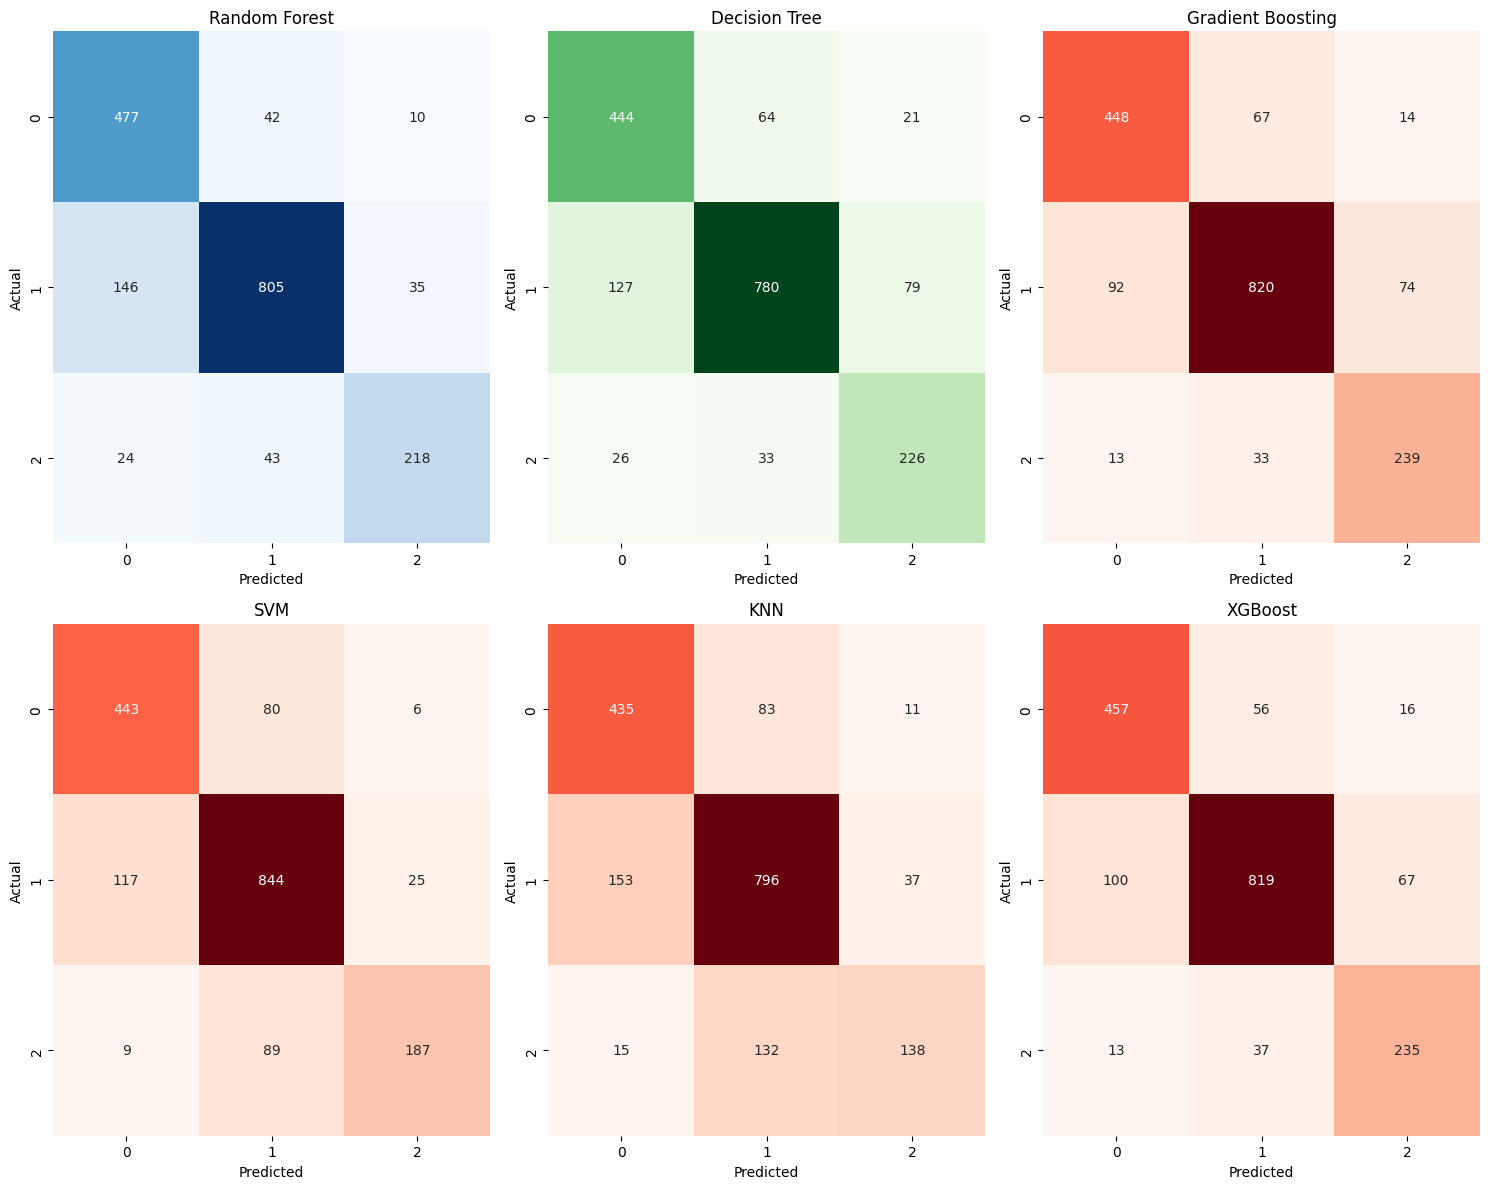

In [50]:
###################Confusion Matrix####################

cm_rf = confusion_matrix(y_test, rf_prediction)
cm_dt = confusion_matrix(y_test, dt_prediction)
cm_gb = confusion_matrix(y_test, gb_prediction)
cm_svm = confusion_matrix(y_test, svm_prediction)
cm_knn = confusion_matrix(y_test, knn_prediction)
cm_xgb = confusion_matrix(y_test, xgb_prediction)

plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 2)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 3)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 4)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 5)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 6)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()


In [51]:
###################Classification Report####################
print("\nRandomForest Classification Report:")
print(classification_report(y_test, rf_prediction))

print("\nDecision Tree Classification Report:")
print(classification_report(y_test, dt_prediction))

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, gb_prediction))

print("\nSVM Classification Report:")
print(classification_report(y_test, svm_prediction))

print("\nKNN Classification Report:")
print(classification_report(y_test, knn_prediction))

print("\nXGBOOST Classification Report:")
print(classification_report(y_test, xgb_prediction))


RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       529
           1       0.90      0.82      0.86       986
           2       0.83      0.76      0.80       285

    accuracy                           0.83      1800
   macro avg       0.82      0.83      0.82      1800
weighted avg       0.84      0.83      0.83      1800


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       529
           1       0.89      0.79      0.84       986
           2       0.69      0.79      0.74       285

    accuracy                           0.81      1800
   macro avg       0.78      0.81      0.79      1800
weighted avg       0.82      0.81      0.81      1800


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       529
           1

In [52]:
################################THE SCRIPT#######################################
def encode_with_unknown(label_encoder, column):
    # Replace unseen categories with -1
    encoded = column.apply(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)
    return encoded
def preprocess_data(new):
    # Convert dataframe to lowercase
    new = new.applymap(lambda x: x.lower() if isinstance(x, str) else x)
    
    # Fill null values
    new['amenities'] = new['amenities'].fillna(0)
    new['square_feet'] = new['square_feet'].fillna(d5)
    new['bedrooms'] = new['bedrooms'].fillna(X_train['bedrooms'].mode().iloc[0])
    new['bathrooms'] = new['bathrooms'].fillna(X_train['bathrooms'].mode().iloc[0])
    new['pets_allowed'] = new['pets_allowed'].fillna('No').apply(lambda x: 'Yes' if x != 'No' else x)
    new['address'] = new['address'].fillna("Unknown")
    new['cityname'] = new['cityname'].fillna(d1)
    new['state'] = new['state'].fillna(d2)
    new['latitude'] = new['latitude'].fillna(X_train['longitude'].mean())
    new['longitude'] = new['longitude'].fillna(X_train['longitude'].mean())
    new['price_type'] = new['price_type'].replace({'Weekly': 'Monthly', 'Monthly|Weekly': 'Monthly'})
    new['category'] = new['category'].replace({'housing/rent/short_term': 'housing/rent/apartment', 'housing/rent/home': 'housing/rent/apartment'})
    

    
    # Extract price from body column
    new['extracted_price'] = new['body'].apply(extract_price_df)
    new['extracted_price'] = new['extracted_price'].astype(np.float64)
    
    # Encode amenities
    if new['amenities'].dtype == object:
        new['amenities'] = new['amenities'].apply(encode_amenities)
    
    # Label encoding
    label_encoder = load('le.joblib')  # Load label encoder
    new['source'] = encode_with_unknown(label_encoder, new['source'])
    new['price_type'] = encode_with_unknown(label_encoder, new['price_type'])
    new['address'] = encode_with_unknown(label_encoder, new['address'])
    new['body'] = encode_with_unknown(label_encoder, new['body'])
    new['title'] = encode_with_unknown(label_encoder, new['title'])
    new['pets_allowed'] = encode_with_unknown(label_encoder, new['pets_allowed'])
    new['has_photo'] = encode_with_unknown(label_encoder, new['has_photo'])
    new['fee'] = encode_with_unknown(label_encoder, new['fee'])
    new['currency'] = encode_with_unknown(label_encoder, new['currency'])
    

    columns_to_drop = ['id', 'category', 'title', 'body', 'currency', 'fee', 'source', 'time','price_type','address']
    new = new.drop(columns=columns_to_drop)
    
    # Add new features
    new['NoOfRooms'] = new['bathrooms']+new['bedrooms']
    new['bed/bathrooms'] = new['bedrooms'] / new['bathrooms']
    
    
    city_encoding = X_train.groupby(d4)['extracted_price'].mean().reset_index()
    city_encoding.columns = ['cityname', 'city_price_mean']
    new = pd.merge(new, city_encoding, on='cityname', how='left')
    new['cityname']=new['city_price_mean']
    new.drop(['city_price_mean'], axis=1, inplace=True)
    new['cityname']=new['cityname'].fillna(mostcity)

    #grouping the state according to its names and replacing with the avg price of each state
    state_encoding = X_train.groupby(d3)['extracted_price'].mean().reset_index()
    print(state_encoding)
    state_encoding.columns = ['state', 'state_price_mean']
    new = pd.merge(new, state_encoding, on='state', how='left')
    new['state']=new['state_price_mean']
    new.drop(['state_price_mean'], axis=1, inplace=True)
    new['state'] =new['state'].fillna(moststate)
    new = new.rename(columns={'cityname': 'CityavgRentprice', 'state': 'StateavgRentprice'})
    
    ##############New Feature ALERTTTTT############ AvgAreaState
    X_train['longitude_range'] = pd.cut(X_train['longitude'], bins=10)
    X_train['latitude_range'] = pd.cut(X_train['latitude'], bins=10)

    
    range_means = X_train.groupby(['longitude_range', 'latitude_range'])['extracted_price'].mean()


    new['AvgAreaPrice'] = X_train.groupby(['longitude_range', 'latitude_range'])['extracted_price'].transform('mean')
    
    X_train.drop(['longitude_range', 'latitude_range'], axis=1, inplace=True)
    new['CityStateAvg'] = (new['CityavgRentprice'] + new['StateavgRentprice']) / 2
    bath_encoding = X_train.groupby('bathrooms')['extracted_price'].mean().reset_index()
    bath_encoding.columns = ['bathrooms', 'avgBathroomsPrice']
    new = pd.merge(new, bath_encoding, on='bathrooms', how='left')
    new["avgBathroomsPrice"]= new["avgBathroomsPrice"].fillna(mostBath)
    new['Trial'] = new['CityavgRentprice'] + new['square_feet'] / 2 + new['avgBathroomsPrice'] / 3 + new['bedrooms'] * 20
    print(new.isna().sum())
    # Select top k features
    selected_features = new[['amenities','bathrooms','bedrooms','has_photo','pets_allowed','square_feet','CityavgRentprice','StateavgRentprice','latitude','longitude','extracted_price','NoOfRooms','bed/bathrooms','AvgAreaPrice','CityStateAvg','avgBathroomsPrice','Trial']]
    X = selected_features
    new['RentCategory'] = new['RentCategory'].apply(lambda x: x.lower().replace(' ', ''))
    new['RentCategory']=new['RentCategory'].apply(categorize_rent_category)
    new['RentCategory'] = new['RentCategory'].apply(encode_rent_category)
    y=new['RentCategory']
    # Scale features
    scaler = load('sc.joblib')
    X_scaled = scaler.transform(X)
    print(X)
#     dffff=pd.DataFrame(X_scaled)
#     print(dffff.isna().sum())
    # Select top features
    selector = load('selector.joblib')
    X_selected = selector.transform(X_scaled)
    
    return X_selected,y


def test_model(dl):
    X, y = preprocess_data(dl)  
    model1 = load('rf.joblib')  
    y_pred1 = model1.predict(X)
    model2 = load('xgb.joblib')  
    y_pred2 = model2.predict(X)
    model3 = load('gb.joblib')  
    y_pred3 = model3.predict(X)
    accuracy1 = accuracy_score(y, y_pred1)
    print("Accuracy Model1 RandomForest:", accuracy1)
    accuracy2 = accuracy_score(y, y_pred2)
    print("Accuracy Model2 XGB:", accuracy2)
    accuracy3 = accuracy_score(y, y_pred3)
    print("Accuracy Model2 GB:", accuracy3)




In [238]:
#######################new data here####################################################
new_df = pd.read_csv("ApartmentRentPrediction_tryy.csv")
test_model(new_df)

        cityname  extracted_price
0       aberdeen          1587.00
1        abilene          2000.75
2       abington             0.00
3        absecon           770.00
4        addison           625.00
...          ...              ...
1215  youngstown          1525.00
1216   ypsilanti           809.40
1217   yuba city             0.00
1218       yukon           575.00
1219     zachary           250.00

[1220 rows x 2 columns]
   state  extracted_price
0     ak       875.363636
1     al       893.085714
2     ar       915.976744
3     az      1064.613333
4     ca       986.625000
5     co       984.721591
6     ct       911.779661
7     dc       912.264706
8     de       897.250000
9     fl      1091.346734
10    ga      1081.723502
11    hi       790.000000
12    ia      1012.299145
13    id       995.090909
14    il      1099.084337
15    in      1012.825758
16    ks       843.733333
17    ky       944.037037
18    la      1324.000000
19    ma      1070.326087
20    md      1075.75

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6504\1697627179.py:105: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  new = pd.merge(new, bath_encoding, on='bathrooms', how='left')
C:\Users\Lenovo\anaconda33\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\anaconda33\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
